<a href="https://colab.research.google.com/github/ErycaFMS/DS_Projeto/blob/main/Projeto_Data_Science_Finalizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Definição do Problema

O dataset utilizado neste projeto é proveniente do sistema SCADA de uma turbina eólica localizada na Turquia. **O objetivo principal é prever a potência ativa gerada por um aerogerador com base em variáveis relacionadas às condições do vento e à potência teórica do sistema.**

O dataset foi coletado em intervalos de 10 minutos e contém informações que possibilitam otimizar o desempenho do aerogerador e melhorar a eficiência energética. A previsão da potência ativa contribui para decisões mais eficazes em sistemas de energia renovável, promovendo uma gestão otimizada dos recursos e da produção energética. Para mais detalhes sobre este dataset, consulte: https://www.kaggle.com/datasets/berkerisen/wind-turbine-scada-dataset?resource=download&select=T1.csv

**Este problema é classificado como uma tarefa de regressão**, pois envolve prever valores contínuos da potência ativa. **As premissas do projeto incluem** a suposição de uma relação linear (ou não linear) entre as variáveis independentes, como velocidade do vento e potência teórica, e a potência ativa. Também se assume que os dados são representativos do fenômeno a ser modelado e foram coletados em condições normais, além de garantir a independência das amostras.

**Restrições ou Condições na Seleção dos Dados:** Na seleção dos dados, foram removidos outliers, como os valores negativos de potência ativa, que são incoerentes. Apenas foram considerados dados com velocidades de vento válidas, variando de 0 a 25,206 m/s. Além disso, foram utilizadas somente as variáveis que impactam diretamente a previsão da potência ativa, incluindo a velocidade do vento, a potência teórica e a direção do vento.

**Informações sobre os atributos:**

1. **Date/Time**: Data e hora em que a medição foi realizada (intervalos de 10 minutos).
2. **ActivePower** (kW): Potência ativa gerada pela turbina no momento da medição, em quilowatts.
3. **Wind Speed** (m/s): Velocidade do vento na altura do eixo da turbina, medida em metros por segundo. Esta é a velocidade do vento utilizada para a geração de eletricidade.
4. **Theoretical_Power_Curve** (KWh): Valores teóricos de potência que a turbina pode gerar com a velocidade do vento fornecida, conforme especificado pelo fabricante da turbina, medidos em quilowatt-hora.
5. **Wind Direction** (°): Direção do vento na altura do eixo da turbina, medida em graus. As turbinas eólicas ajustam-se automaticamente para se alinhar com esta direção.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms# para tratamento de missings
from matplotlib import cm
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

## 2. Carga de Dados

Iremos usar o pacote Pandas (Python Data Analysis Library) para carregar de um arquivo .csv sem cabeçalho disponível online.

Com o dataset carregado, iremos explorá-lo um pouco.

In [3]:
# Carrega arquivo csv usando Pandas usando uma URL

# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/ErycaFMS/DS_Projeto/main/T1.csv"

# Informa o cabeçalho das colunas
colunas = ['Data/Hora', 'Potência Ativa [kW]', 'Velocidade do Vento [m/s]', 'Potência Teórica [kW]', 'Direção do Vento [°]']

# Lê o arquivo utilizando as colunas informadas
dataset = pd.read_csv(url, names=colunas, skiprows=1, delimiter=',')

# Converte a coluna 'Data/Hora' de string para datetime
dataset['Data/Hora'] = pd.to_datetime(dataset['Data/Hora'], format='%d %m %Y %H:%M')

In [4]:
dataset.head()

,Data/Hora,Potência Ativa [kW],Velocidade do Vento [m/s],Potência Teórica [kW],Direção do Vento [°]
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


## 3. Análise de Dados

### 3.1. Estatísticas Descritivas

Vamos iniciar examinando as dimensões do dataset, suas informações e alguns exemplos de linhas.

In [5]:
# Mostra as dimensões do dataset
print(dataset.shape)

(50530, 5)


In [6]:
# Mostra as informações do dataset
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Data/Hora                  50530 non-null  datetime64[ns]
 1   Potência Ativa [kW]        50530 non-null  float64       
 2   Velocidade do Vento [m/s]  50530 non-null  float64       
 3   Potência Teórica [kW]      50530 non-null  float64       
 4   Direção do Vento [°]       50530 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.9 MB
None


In [7]:
# Mostra as 10 primeiras linhas do dataset
dataset.head(10)

,Data/Hora,Potência Ativa [kW],Velocidade do Vento [m/s],Potência Teórica [kW],Direção do Vento [°]
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286
5,2018-01-01 00:50:00,402.391998,5.604052,499.436385,264.578613
6,2018-01-01 01:00:00,447.605713,5.793008,557.372363,266.163605
7,2018-01-01 01:10:00,387.242188,5.306050,414.898179,257.949493
8,2018-01-01 01:20:00,463.651215,5.584629,493.677652,253.480698
9,2018-01-01 01:30:00,439.725708,5.523228,475.706783,258.723785


In [8]:
# Mostra as 10 últimas linhas do dataset
dataset.tail(10)

,Data/Hora,Potência Ativa [kW],Velocidade do Vento [m/s],Potência Teórica [kW],Direção do Vento [°]
50520,2018-12-31 22:20:00,2771.110107,10.154550,2884.512812,82.335197
50521,2018-12-31 22:30:00,3333.819092,12.067660,3532.081496,81.985901
50522,2018-12-31 22:40:00,3455.282959,12.195660,3549.150371,82.210617
50523,2018-12-31 22:50:00,3429.021973,12.492510,3578.567804,82.111870
50524,2018-12-31 23:00:00,3514.269043,12.559170,3583.288363,80.495262
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913
50529,2018-12-31 23:50:00,2820.466064,9.979332,2779.184096,82.274620


É sempre importante verificar o tipo do atributos do dataset, pois pode ser necessário realizar conversões. Já fizemos anteriormente com o comando info, mas vamos ver uma outra forma de verificar a natureza de cada atributo e então exibir um resumo estatístico do dataset. **O atributo "Data/Hora" estava classificado como string, e no Tópico 2: Carga de Dados foi convertida para um objeto datetime , a fim de facilitar sua manipulação estatística.**

In [9]:
# Verifica o tipo de dataset de cada atributo
dataset.dtypes

,0
Data/Hora,datetime64[ns]
Potência Ativa [kW],float64
Velocidade do Vento [m/s],float64
Potência Teórica [kW],float64
Direção do Vento [°],float64


In [10]:
# Faz um resumo estatístico do dataset (média, desvio padrão, mínimo, máximo e os quartis)
dataset.describe()

,Data/Hora,Potência Ativa [kW],Velocidade do Vento [m/s],Potência Teórica [kW],Direção do Vento [°]
count,50530,50530.000000,50530.000000,50530.000000,50530.000000
mean,2018-07-01 20:01:30.065307648,1307.684332,7.557952,1492.175463,123.687559
min,2018-01-01 00:00:00,-2.471405,0.000000,0.000000,0.000000
25%,2018-04-03 05:22:30,50.677890,4.201395,161.328167,49.315437
50%,2018-06-30 16:15:00,825.838074,7.104594,1063.776283,73.712978
75%,2018-09-26 18:57:30,2482.507568,10.300020,2964.972462,201.696720
max,2018-12-31 23:50:00,3618.732910,25.206011,3600.000000,359.997589
std,NaN,1312.459242,4.227166,1368.018238,93.443736


**Notamos que o valor mínimo de Potência Ativa é negativo**, evidenciando futura necessidade de tratamento de dados.

### 3.2. Visualizações Unimodais

Vamos criar agora um histograma para cada atributo do dataset. Veremos que o atributo Velocidade do Vento segue uma distribuição aproximadamente normal.

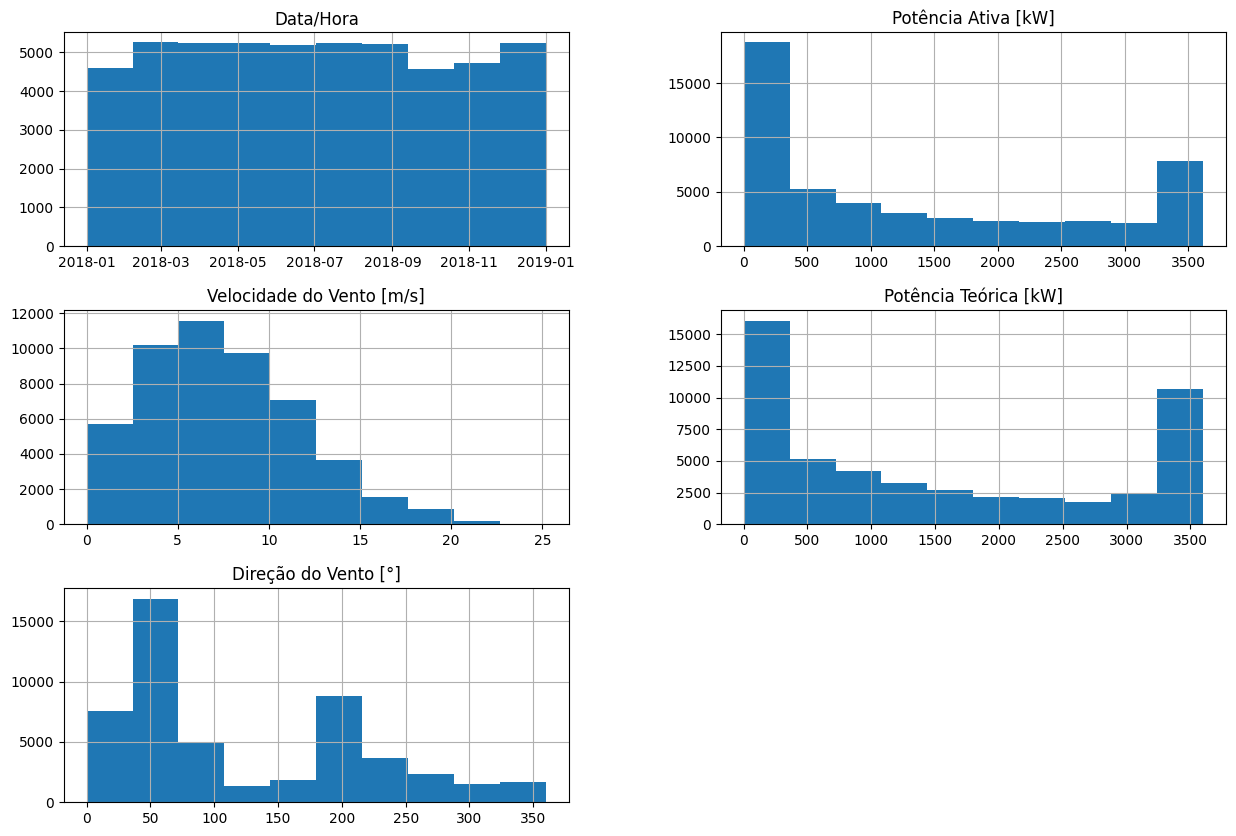

In [11]:
# Histograma
dataset.hist(figsize = (15,10))
plt.show()

O Gráfico de Densidade, ou Density Plot, é bem parecido com o histograma, mas com uma visualização um pouco diferente. Com ele, pode ser mais fácil identificar a distribuição do atributos do dataset. Assim como fizemos com o histograma, vamos criar um density plot para cada atributo do dataset.

Veremos que muitos dos atributos têm uma distribuição distorcida. Uma transformação como a Box-Cox, que pode aproximar a distribuição de uma Normal, pode ser útil neste caso.

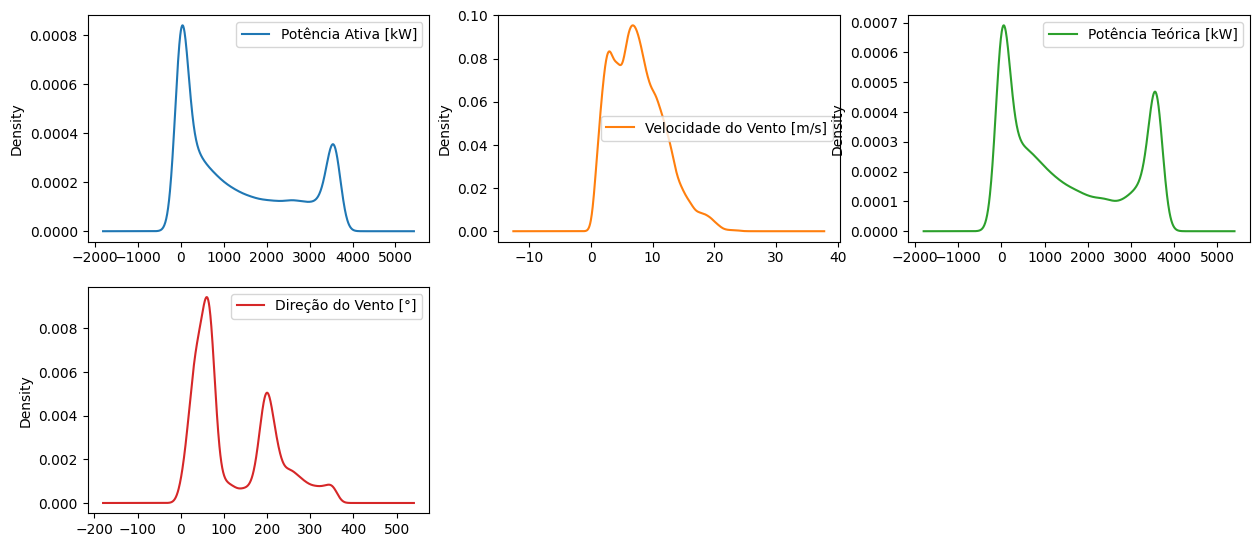

In [12]:
# Remove a coluna 'Data/Hora' para o plot de densidade
dataset_numerico = dataset.drop(columns=['Data/Hora'])

# Density Plot
dataset_numerico.plot(kind = 'density', subplots = True, layout = (3,3), sharex = False, figsize = (15,10))
plt.show()

Vamos agora trabalhar com boxplots. No **boxblot**, a linha no centro (vermelha) representa o valor da mediana (segundo quartil ou p50). A linha abaixo é o 1o quartil (p25) e a linha acima o terceiro quartil (p75). O boxplot ajuda a ter uma ideia da dispersão dos dataset e os possíveis outliers.

*OBS: Se um ponto do dataset é muito distante da média (acima de 3 desvios padrão da média), pode ser considerado outlier.*

Nos gráficos bloxplot, veremos que a dispersão dos atributos do dataset é bem diferente.

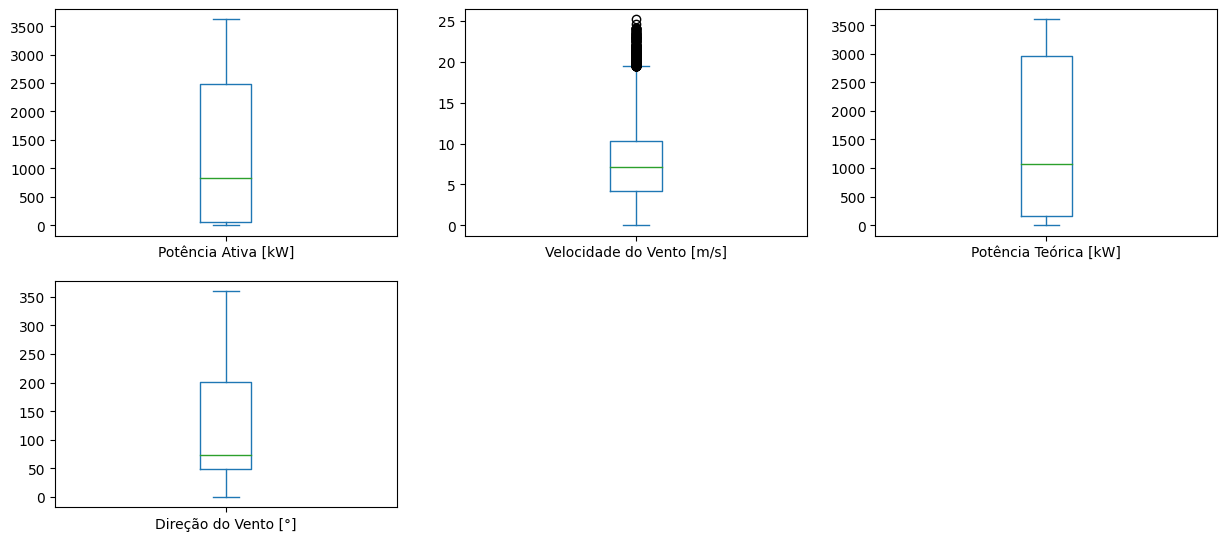

In [13]:
# Boxplot
dataset.plot(kind = 'box', subplots = True, layout = (3,3), sharex = False, sharey = False, figsize = (15,10))
plt.show()

### 3.3. Visualizações Multimodais

Ao visualizar as correlações entre os atributos através da matriz de correlação, perceberemos que parece haver alguma estrutura na ordem dos atributos. O azul ao redor da diagonal sugere que os atributos que estão próximos um do outro são geralmente mais correlacionados entre si. Os vermelhos também sugerem alguma correlação negativa moderada, a medida que os atributos estão mais distantes um do outro na ordenação.

Vamos agora verificar a covariância entre as variáveis numéricas do dataset. A **covariância** representa como duas variáveis numéricas estão relacionadas. Existem várias formas de calcular a correlação entre duas variáveis, como por exemplo, o coeficiente de correlação de Pearson, que pode ser:
* Próximo de -1 : há uma correlação negativa entre as variáveis,
* Próximo de +1: há uma correlação positiva entre as variáveis.
* 0: não há correlação entre as variáveis.

<i>OBS: Esta informação é relevante porque alguns algoritmos como regressão linear e regressão logística podem apresentar problemas de performance se houver atributos altamente correlacionados. Vale a pena consultar a documentação do algoritmo para verificar se algum tipo de tratamento de dataset é necessário.</i>

Falamos anteriormente da importância da correlação entre os atributos, e agora iremos visualizar esta informação em formato gráfico. A **matriz de correlação** exibe graficamente a correlação entre os atributos numéricos do dataset.

O código a seguir exibe a matriz de correlação.

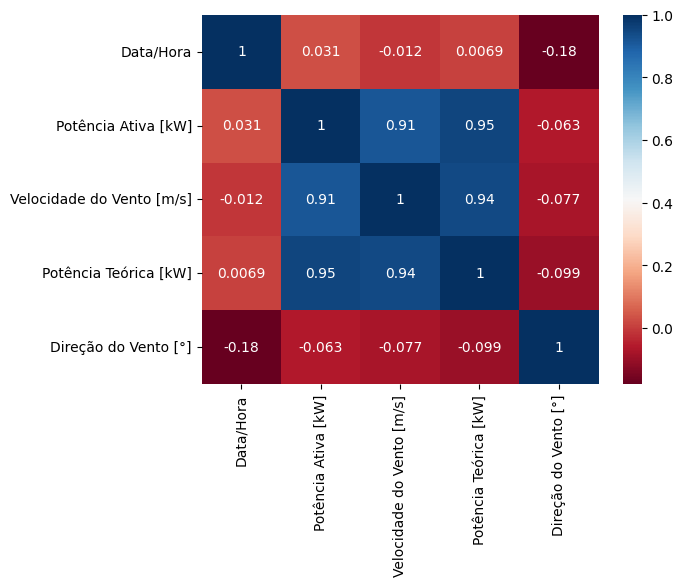

In [14]:
# Matriz de Correlação com Matplotlib Seaborn
sns.heatmap(dataset.corr(), annot=True, cmap='RdBu');

Sendo assim, é evidente que **as variáveis que apresentam maior correlação entre si são a velocidade do vento e as Potências.** Dessa forma, serão elas que iremos analisar para construir nosso modelo de previsão.

Por sua vez, o gráfico de dispersão (**scatter plot**) mostra o relacionamento entre duas variáveis. Vamos exibir um para cada par de atributos dos dataset, usando o Seaborn.

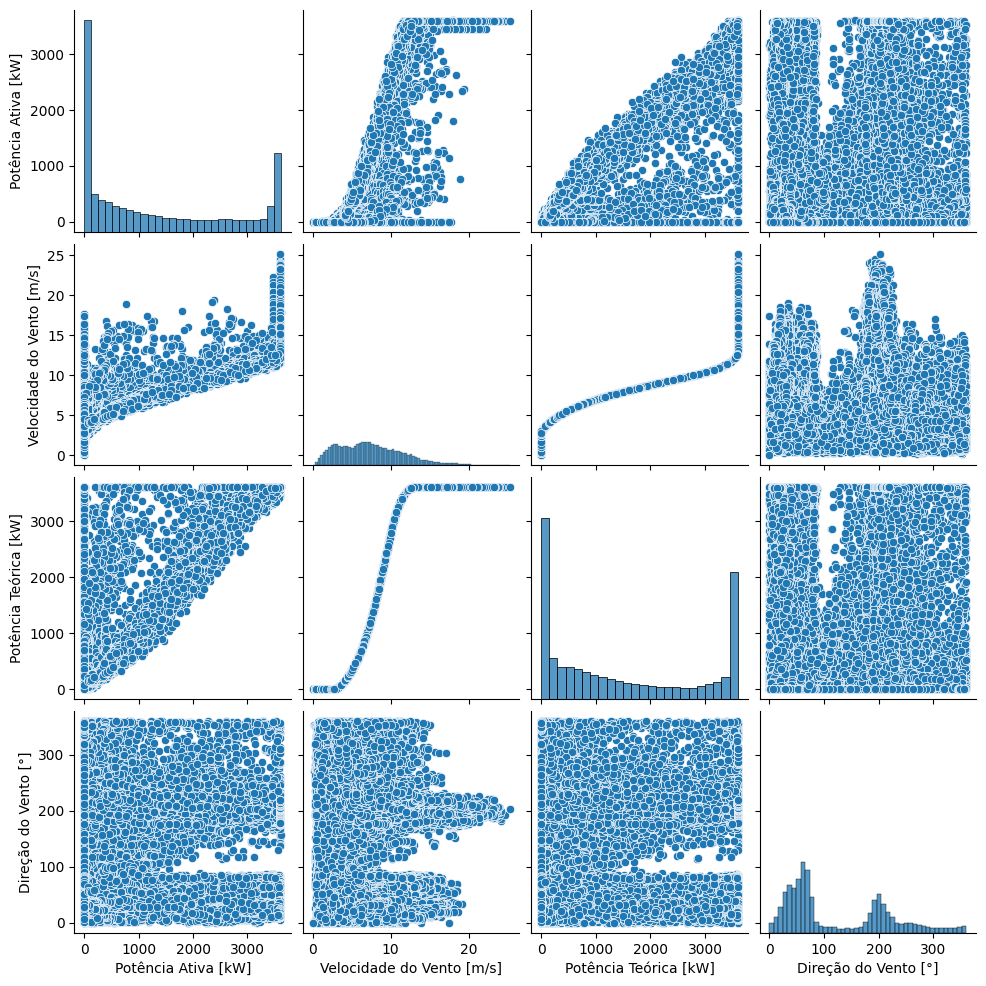

In [15]:
# Scatter Plot com Seaborn - Variação 1

sns.pairplot(dataset)

Ao observarmos o gráfico de Potência Teórica versus Velocidade do Vento, **visualizamos o cenário ideal para análise**. Os gráficos destacam a **necessidade de uma limpeza nos dados de Potência Ativa, o que permitirá otimizar os modelos de regressão e melhorar a performance das previsões**, utilizando dados mais alinhados com a realidade.

## 4. Preparação dos dados

Nesta etapa, foram utilizadas algumas operações de preparações de dados, como: **Limpeza de dados:** Remoção de outliers através da função remover_outliers, que filtra valores de potência ativa negativos e valores anômalos de velocidade do vento.
**Verificação de valores faltantes:** A verificação de valores nulos foi realizada usando dataset.isnull().sum().
**Seleção de características (feature selection):** O foco foi dado a variáveis que impactam diretamente a previsão da potência ativa, como velocidade do vento, potência teórica e potência ativa.
Operações como padronização e normalização dos dados foram evitadas nesta fase para prevenir o Data Leakage.

### 4.1. Tratamento de Missings e Limpeza

Devemos realizar um tratamento de dados para os valores de potência que aparecem negativos, além dos missings, criando uma nova visão do nosso dataset. Antes, salvaremos uma cópia do dataset original (**dataset_sem_filtro**) para tratamento de outliers, a fim de não sobrescrever o dataset original.

**Comparação das curvas antes da limpeza**

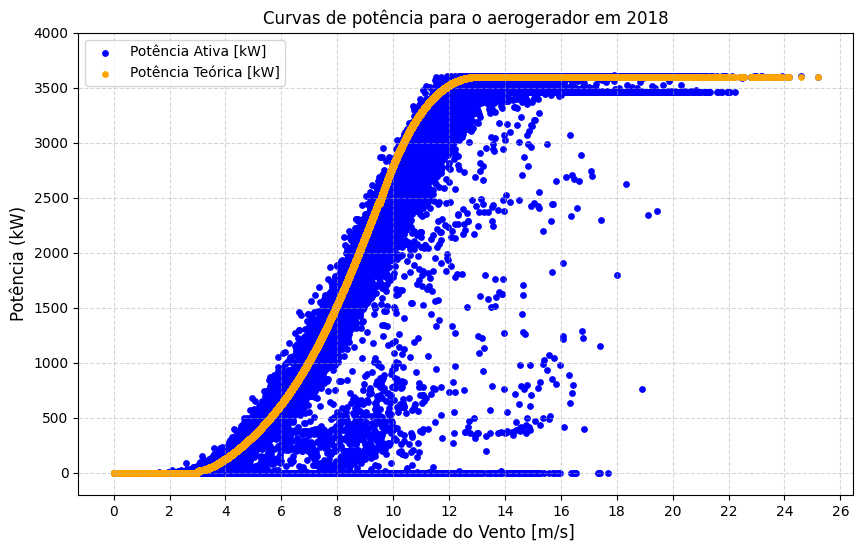

In [16]:
# Plotar curvas de potência para o aerogerador

# Preparar a figura
plt.figure(figsize=(10, 6))

# Potência ativa
plt.scatter(dataset['Velocidade do Vento [m/s]'], dataset['Potência Ativa [kW]'], label='Potência Ativa [kW]', color='blue', marker="o", s=15)

# Potência teórica
plt.scatter(dataset['Velocidade do Vento [m/s]'], dataset['Potência Teórica [kW]'], label='Potência Teórica [kW]', color='orange', marker="o", s=15)

# Exibir legenda
plt.legend()

# Nomenclatura dos eixos x e y
plt.xlabel('Velocidade do Vento [m/s]', fontsize=12)
plt.ylabel('Potência (kW)', fontsize=12)
plt.title('Curvas de potência para o aerogerador em 2018')

# Definir explicitamente os limites do eixo x
xmin = 0  # Especificar o limite inferior
xmax = 26  # Especificar o superior
x_step = 2  # Especificar o passo
plt.xticks(np.arange(xmin, xmax+1, x_step), fontsize=10) # Definir passo e tamanho de fonte dos ticks do eixo x

# Definir limites e o passo no eixo y
ymin = 0  # Especificar o limite inferior
ymax = 4000  # Especificar o superior
y_step = 500  # Especificar o passo
plt.yticks(np.arange(ymin, ymax+1, y_step), fontsize=10) # Definir passo e tamanho de fonte dos ticks do eixo y
plt.ylim(ymin-200, ymax)

# Adicionar grids no gráfico
plt.grid(True, linestyle='--', alpha=0.5)

# Exibir o gráfico
plt.show()

In [17]:
# verificando nulls no dataset
dataset.isnull().sum()

,0
Data/Hora,0
Potência Ativa [kW],0
Velocidade do Vento [m/s],0
Potência Teórica [kW],0
Direção do Vento [°],0


In [18]:
#Criando cópia do Dataset
dataset_sem_filtro = dataset.copy()

### 4.2. Procedimento de remoção de outliers

Removeremos outliers em uma coluna específica do Dataframe, a partir dos percentis definidos (mínimo e máximo) para a coluna. Assim, retornando apenas as linhas onde os valores estão dentro do intervalo definido, removendo os valores considerados outliers (fora desse intervalo).

In [19]:
# Função para remover outliers
def remover_outliers(df, coluna, percentil_min, percentil_max):
    """
    Essa função remove os outliers de um coluna específica do dataset,
    utilizando percentis mínimo e máximo.
    """
    # Calcula os quartis para os percentis mínimos e máximos
    q_baixo = df[coluna].quantile(percentil_min)
    q_alto = df[coluna].quantile(percentil_max)

    # Filtra o DataFrame mantendo apenas os valores dentro do intervalo definido pelos quartis
    return df[(df[coluna] < q_alto) & (df[coluna] > q_baixo)]

Dividindo o dataset em subconjuntos com base em intervalos de valores da coluna 'Potência Ativa [kW]' (50 passos por padrão) e os armazenando em um dicionário.

In [20]:
# Função para criar subconjuntos de dados
def criar_subconjuntos_de_dados(data, passo=50, limite_superior=3400):
    """
    Essa função divide o dataset em subconjuntos com base nos valores da
    coluna 'Potência Ativa [kW]'. Cada subconjunto abrange um intervalo
    específico (definidos pelo passo) e armazena o subconjunto num
    dicionário. Cada subconjunto é representado por um intervalo inferior
    e o último subconjunto inclui valores maiores ou iguais a 3300.
    """
    subconjuntos = {}
    for limite_inferior in range(20, limite_superior, passo):
        limite_superior_atual = limite_inferior + passo
        # Condição para criar o subconjunto baseado nos limites
        condicao = (data['Potência Ativa [kW]'] >= limite_inferior) & (data['Potência Ativa [kW]'] < limite_superior_atual)
        subconjuntos[limite_inferior] = data[condicao]

    # Adiciona o último subconjunto para valores >= 3300
    subconjuntos[limite_superior] = data[data['Potência Ativa [kW]'] >= 3300]

    return subconjuntos

Para cada subconjunto, uma faixa específica de percentil máximo (F) é atribuída de acordo com o valor do limite inferior. Por exemplo, se o limite inferior do subconjunto for <= 3, o percentil máximo é 0.95, enquanto para valores maiores de potência ativa, o percentil é ajustado para diferentes valores.
**A função remover_outliers é aplicada em cada subconjunto para a coluna 'Velocidade do Vento [m/s]', removendo os outliers com base nos percentis definidos.**
Por fim, todos os subconjuntos filtrados são concatenados em um único dataset (**dataset_com_filtro**) para uso posterior.

In [21]:
# Criar subconjuntos de dados
subconjuntos_de_dados = criar_subconjuntos_de_dados(dataset_sem_filtro)

# Remoção de outliers para cada subconjunto de dados
for limite_inferior, df in subconjuntos_de_dados.items():
    if limite_inferior <= 3:
        F = 0.95
    elif 3 < limite_inferior <= 10:
        F = 0.90
    elif 10 < limite_inferior <= 20:
        F = 0.92
    elif 20 < limite_inferior < 30:
        F = 0.96
    else:
        F = 0.985

    subconjuntos_de_dados[limite_inferior] = remover_outliers(df, 'Velocidade do Vento [m/s]', 0.0001, F)

# Concatenação dos subconjuntos de dados em um único dataset
dataset_com_filtro = pd.concat(subconjuntos_de_dados.values(), ignore_index=True)

### 4.3. Exibindo os dados após o Procedimento de filtro do Dataset

Assim, geramos um resumo estatístico do dataset com filtro e a curva de potência sem outliers. Nota-se que os valores indesejados para potência ativa foram resolvidos com a remoção de outliers.

In [22]:
# Faz um resumo estatístico do dataset (média, desvio padrão, mínimo, máximo e os quartis)
dataset_com_filtro.describe()

,Data/Hora,Potência Ativa [kW],Velocidade do Vento [m/s],Potência Teórica [kW],Direção do Vento [°]
count,38839,38839.000000,38839.000000,38839.000000,38839.000000
mean,2018-07-07 02:41:06.937871872,1744.570823,8.910827,1892.184565,114.859691
min,2018-01-01 00:00:00,20.047741,2.404862,0.000000,0.015678
25%,2018-04-08 22:05:00,549.767120,6.097815,657.484440,49.395340
50%,2018-07-11 11:30:00,1520.890015,8.275046,1691.216713,69.855026
75%,2018-10-04 21:45:00,3057.109009,11.350030,3382.517772,196.770996
max,2018-12-31 23:50:00,3618.732910,20.969219,3600.000000,359.997589
std,NaN,1261.763468,3.638900,1297.773108,85.331172


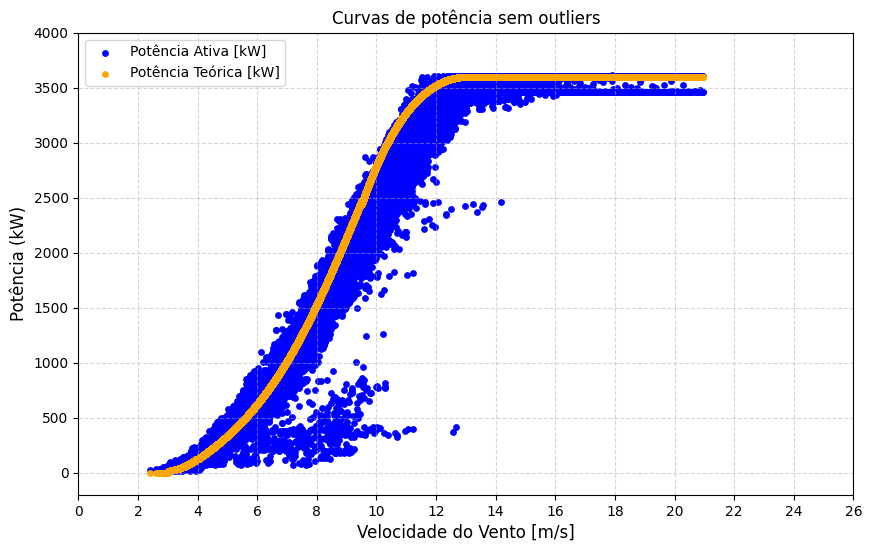

In [23]:
# Plotar curvas de potência para o aerogerador

# Preparar a figura
plt.figure(figsize=(10, 6))

# Potência ativa
plt.scatter(dataset_com_filtro['Velocidade do Vento [m/s]'], dataset_com_filtro['Potência Ativa [kW]'],
            label='Potência Ativa [kW]', color='blue', marker="o", s=15)

# Potência teórica
plt.scatter(dataset_com_filtro['Velocidade do Vento [m/s]'], dataset_com_filtro['Potência Teórica [kW]'],
            label='Potência Teórica [kW]', color='orange', marker="o", s=15)

# Exibir legenda
plt.legend()

# Nomenclatura dos eixos x e y
plt.xlabel('Velocidade do Vento [m/s]', fontsize=12)
plt.ylabel('Potência (kW)', fontsize=12)
plt.title('Curvas de potência sem outliers')

# Definir explicitamente os limites do eixo x
xmin = 0  # Especificar o limite inferior
xmax = 26  # Especificar o superior
x_step = 2  # Especificar o passo
plt.xticks(np.arange(xmin, xmax+1, x_step), fontsize=10) # Definir passo e tamanho de fonte dos ticks do eixo x

# Definir limites e o passo no eixo y
ymin = 0  # Especificar o limite inferior
ymax = 4000  # Especificar o superior
y_step = 500  # Especificar o passo
plt.yticks(np.arange(ymin, ymax+1, y_step), fontsize=10) # Definir passo e tamanho de fonte dos ticks do eixo y
plt.ylim(ymin-200, ymax)

# Adicionar grids no gráfico
plt.grid(True, linestyle='--', alpha=0.5)

# Exibir o gráfico
plt.show()

<Axes: >

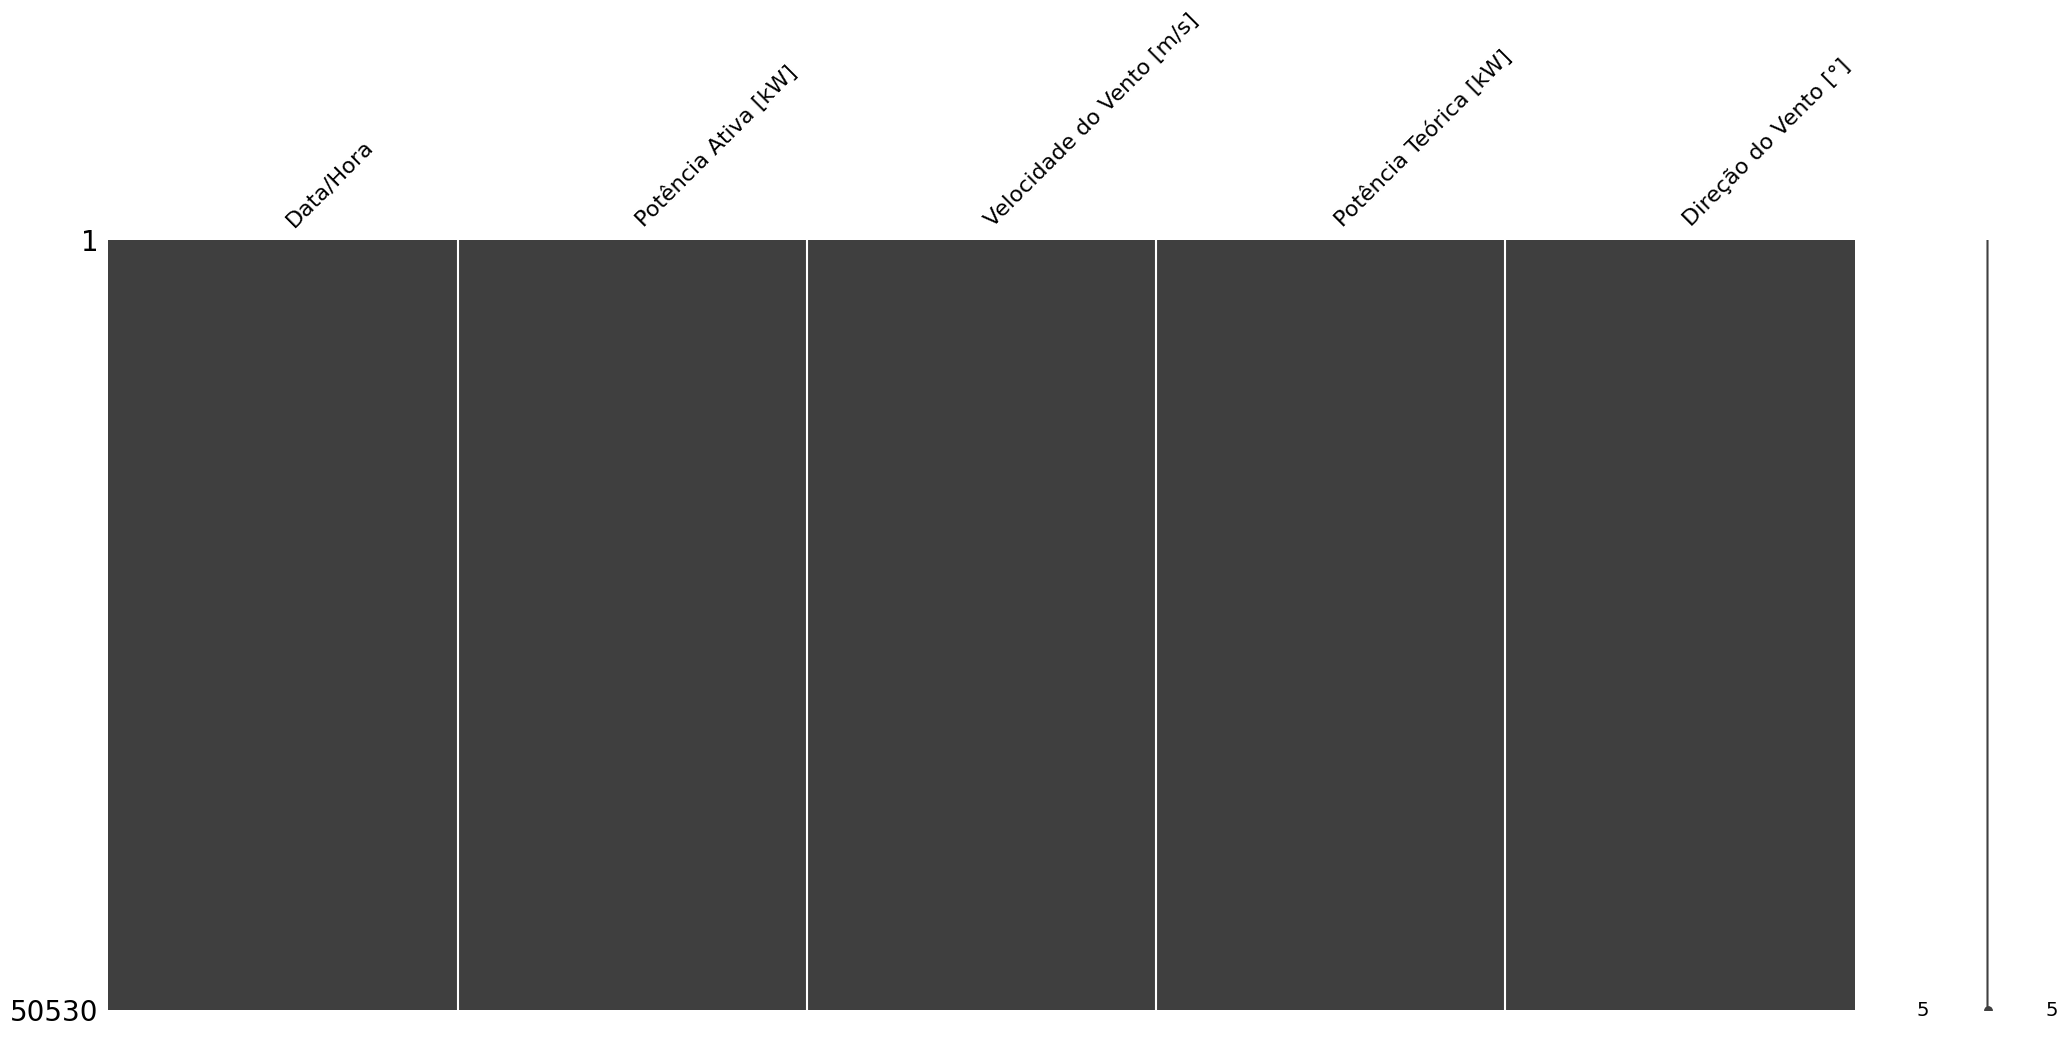

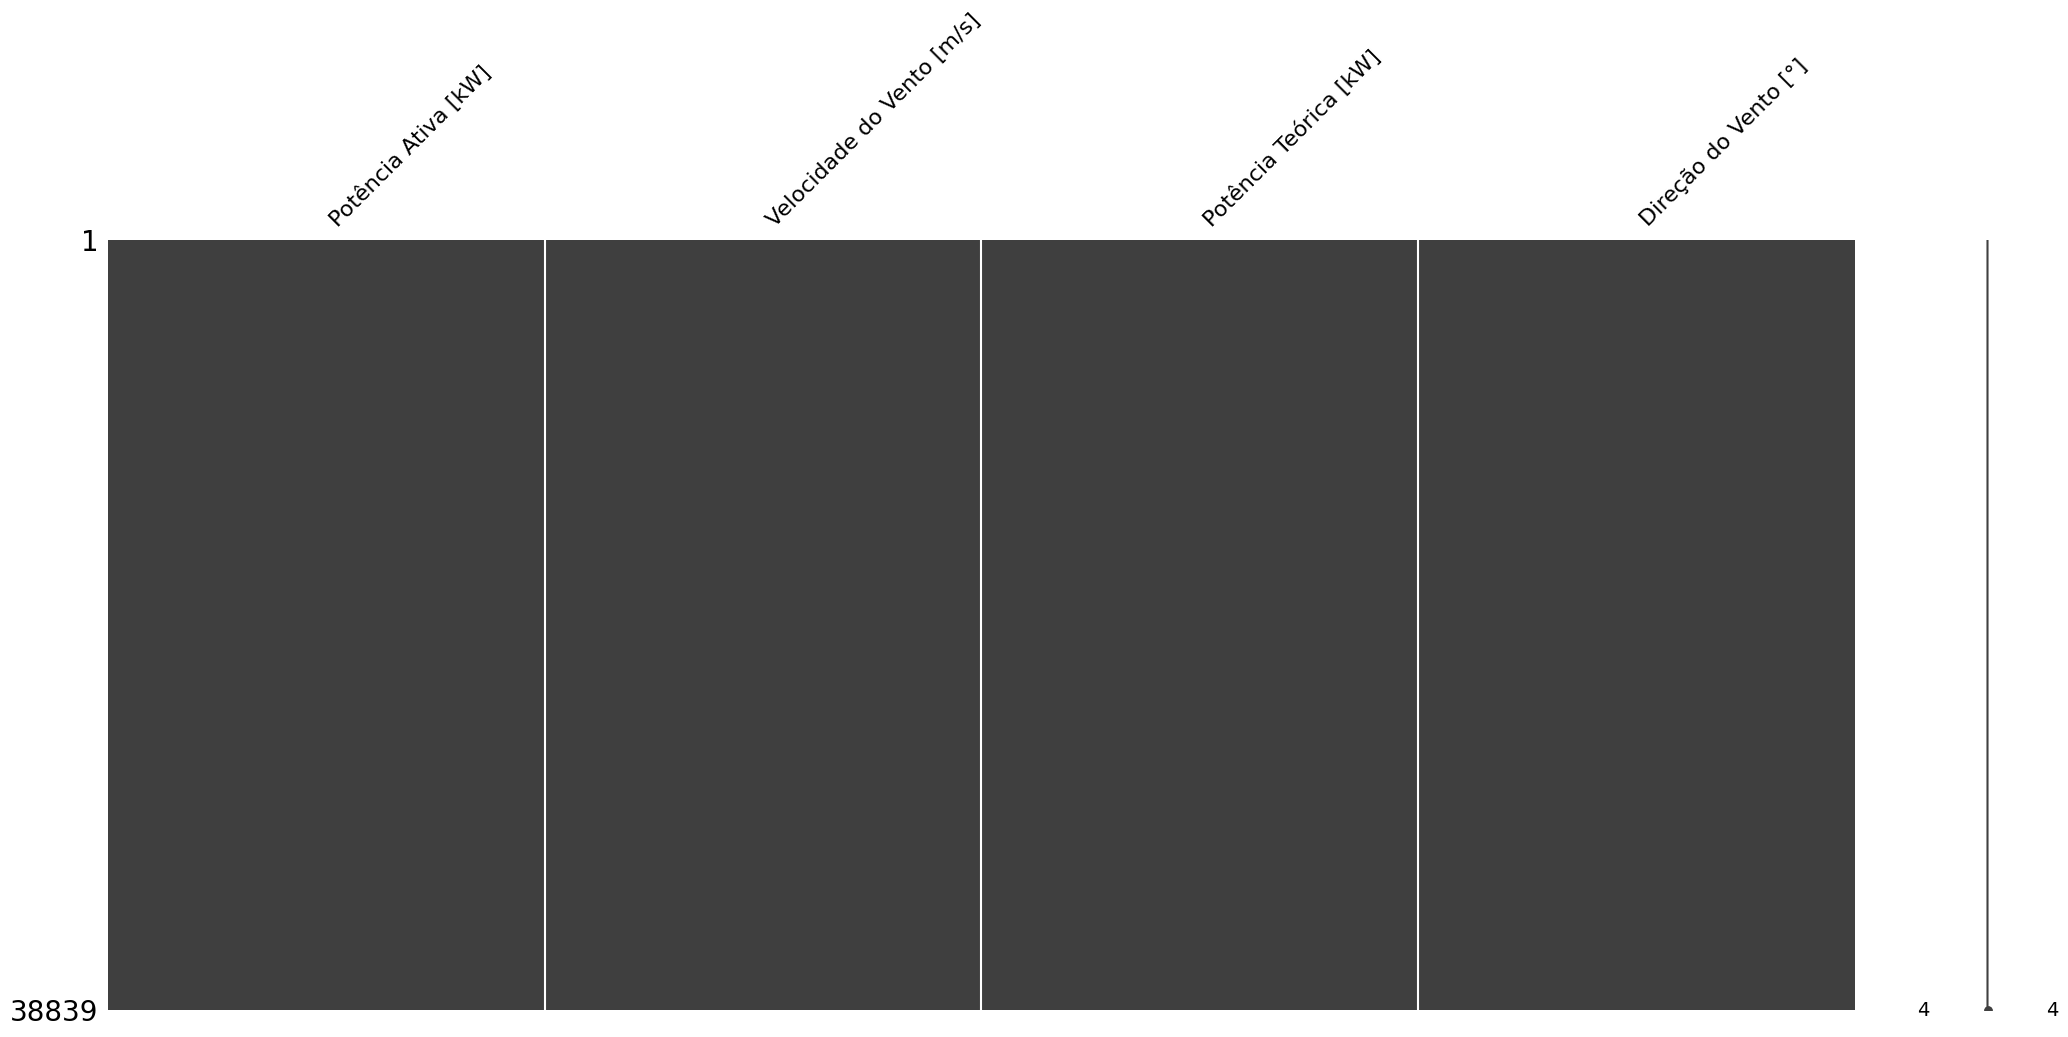

In [24]:
# Exibindo visualização matricial da nulidade antes e depois do tratamento
ms.matrix(dataset_sem_filtro)

# removendo a coluna Data/Hora
dataset_com_filtro.drop(['Data/Hora'], axis=1, inplace= True)
ms.matrix(dataset_com_filtro)

### 4.4. Separação em conjunto de treino e conjunto de teste

É uma boa prática usar um conjunto de teste (na literatura também chamado de conjunto de validação), uma amostra dos dados que não será usada para a construção do modelo, mas somente no fim do projeto para confirmar a precisão do modelo final. É um teste que podemos usar para verificar o quão boa foi a construção do modelo, e para nos dar uma ideia de como o modelo irá performar nas estimativas em dados não vistos. Usaremos 80% do conjunto de dados para modelagem e guardaremos 20% para teste, usando a estratégia train-test-split, já explicada anteriormente. Primeiramente, iremos sinalizar quais são as colunas de atributos (X - 0 a 7) e qual é a coluna das classes (Y - 8). Em seguida, especificaremos o tamanho do conjunto de teste desejado e uma semente (para garantir a reprodutibilidade dos resultados). Finalmente, faremos a separação dos conjuntos de treino e teste através do comando train_test_split, que retornará 4 estruturas de dados: os atributos e classes para o conjunto de teste e os atributos e classes para o conjunto de treino.


In [25]:
# Selecionando as variáveis
X = dataset_com_filtro[['Velocidade do Vento [m/s]', 'Potência Teórica [kW]', 'Direção do Vento [°]']]
y = dataset_com_filtro['Potência Ativa [kW]']

# Separar os dados em treino e teste (80% para treino, 20% para teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5. Construindo o Pipeline

### 5.1. Criando o Pipeline de Pré-processamento

Definimos transformações para colunas numéricas e categóricas.

In [26]:
# Definindo colunas numéricas (não há colunas categóricas neste conjunto de dados)
numeric_features = X.columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Como não temos recursos categóricos, não definimos um transformer categórico
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

## 6. Otimização de Hiperparâmetros com Grid Search

### 6.1 Definindo Modelos e Parâmetros

Os algoritmos escolhidos para o problema de previsão da potência ativa de um aerogerador, como Regressão Linear, Árvore de Regressão, SVR, KNN Regressor e Gradient Boosting Regressor, **foram selecionados por suas capacidades de capturar diferentes tipos de padrões nos dados.** A Regressão Linear é indicada quando se espera uma relação linear simples entre as variáveis, como a velocidade do vento e a potência teórica. A Árvore de Regressão e o Gradient Boosting são úteis para captar relações mais complexas e não lineares, permitindo lidar com interações entre variáveis e fornecer previsões mais precisas. O SVR é robusto contra ruídos e é flexível tanto para padrões lineares quanto não lineares, adaptando-se bem aos dados. Já o KNN Regressor funciona bem em situações onde as previsões dependem de vizinhos próximos, capturando padrões locais no dataset. Essa diversidade de algoritmos oferece a oportunidade de avaliar qual modelo se ajusta melhor ao problema, otimizando a previsão da potência ativa com base nas condições do vento e da potência teórica.

Com isso, definiremos uma lista de modelos de regressão e os hiperparâmetros que desejamos otimizar para cada um.

In [27]:
# Definindo os modelos e seus hiperparâmetros
modelos_params = {
    'Regressão Linear': {
        'modelo': LinearRegression(),
        'params': {}  # Regressão Linear não tem hiperparâmetros para ajuste básico
    },
    'Árvore de Regressão': {
        'modelo': DecisionTreeRegressor(),
        'params': {
            'classifier__max_depth': [None, 5, 10],
            'classifier__min_samples_split': [2, 5, 10]
        }
    },
    'SVR': {
        'modelo': SVR(),
        'params': {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf'],
            'classifier__epsilon': [0.1, 0.2, 0.5]
        }
    },
    'KNN Regressor': {
        'modelo': KNeighborsRegressor(),
        'params': {
            'classifier__n_neighbors': [3, 5, 7],
            'classifier__weights': ['uniform', 'distance']
        }
    },
    'Gradient Boosting Regressor': {
        'modelo': GradientBoostingRegressor(),
        'params': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7]
        }
    }
}

### 6.2. Executando Grid Search com Validação Cruzada

Agora, realizaremos o Grid Search com validação cruzada para cada modelo.

Utilizaremos métricas comumente usadas para avaliar o desempenho dos modelos de regressão, como: MAE (Mean Absolute Error), RMSE (Root Mean Squared Error) e R² (R-squared ou Coeficiente de Determinação). O **MAE** é a média das diferenças absolutas entre as previsões do modelo e os valores reais. Ele mede a precisão média das previsões sem considerar a direção do erro (ou seja, se a previsão é maior ou menor que o valor real). **Um MAE menor indica um modelo mais preciso.** Assim, o MAE na faixa de 90-100 kW é considerado razoável no contexto dos dados  deste projeto porque representa uma pequena fração da variação total da potência ativa, que vai de aproximadamente 20 a 3619 kW. Com isso, se considerarmos o intervalo total dos dados, que é de cerca de 3600 kW, um erro médio de 90-100 kW significa que o modelo está errando em cerca de 2,5% da faixa total. Esse nível de erro é relativamente pequeno comparado à amplitude das potências reais, o que indica que o modelo está fazendo previsões com uma precisão aceitável para esse tipo de problema.

O **RMSE** é a raiz quadrada da média das diferenças quadráticas entre as previsões do modelo e os valores reais. Assim como o MAE, ele mede a precisão das previsões, mas dá maior peso a erros maiores devido ao quadrado das diferenças. **Um RMSE menor indica um modelo mais preciso.** Assim como o MAE, o RMSE está na mesma unidade que a variável prevista, mas pode ser mais sensível a outliers devido ao tratamento quadrático. O **R²** é uma medida estatística que indica a proporção da variância dos dados que é explicada pelo modelo. Ele varia de 0 a 1, onde 0 indica que o modelo não explica nenhuma variância e 1 indica que o modelo explica toda a variância. **Um R² próximo de 1 indica que uma grande proporção da variação nos dados é explicada pelo modelo, enquanto um R² próximo de 0 indica que o modelo não é eficaz.**

In [28]:
# Executando Grid Search com validação cruzada
results = []

for name, mp in modelos_params.items():
    model = mp['modelo']
    params = mp.get('params', {})

    # Criando o pipeline com o modelo atual
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    if params:
        # Grid Search com validação cruzada
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=params,
            cv=5,
            scoring='neg_mean_squared_error',  # Ou outro scoring, dependendo do objetivo
            n_jobs=-1
        )

        # Treinando o modelo
        grid_search.fit(X_train, y_train)

        # Melhor modelo encontrado
        best_model = grid_search.best_estimator_
    else:
        # Se não há hiperparâmetros para ajustar
        pipeline.fit(X_train, y_train)
        best_model = pipeline
        grid_search = None

    # Fazendo previsões no conjunto de treinamento
    y_train_pred = best_model.predict(X_train)

    # Fazendo previsões no conjunto de teste
    y_test_pred = best_model.predict(X_test)

    # Calculando métricas para o conjunto de treinamento
    mae_train = mean_absolute_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)

    # Calculando métricas para o conjunto de teste
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)

    # Exibindo os resultados para o conjunto de treinamento e teste
    print(f"Modelo: {name}")
    print(f"MAE (Treinamento): {mae_train}, MAE (Teste): {mae_test}, Melhores Hiperparâmetros: {grid_search.best_params_ if params else 'N/A'}")
    print(f"RMSE (Treinamento): {rmse_train}, RMSE (Teste): {rmse_test}")
    print(f"R² (Treinamento): {r2_train}, R² (Teste): {r2_test}")
    print('-' * 40)

    # Armazenando os resultados
    results.append({
        'Modelo': name,
        'Melhores Hiperparâmetros': grid_search.best_params_ if params else 'N/A',
        'MAE': mae_test,
        'RMSE': rmse_test,
        'R²': r2_test,
        'Pipeline': best_model  # Armazenando o melhor modelo
    })

Modelo: Regressão Linear
MAE (Treinamento): 116.36602231012219, MAE (Teste): 117.38772022397258, Melhores Hiperparâmetros: N/A
RMSE (Treinamento): 184.5023353391326, RMSE (Teste): 192.033151527655
R² (Treinamento): 0.9786059415029087, R² (Teste): 0.976885768839553
----------------------------------------
Modelo: Árvore de Regressão
MAE (Treinamento): 95.69204758592159, MAE (Teste): 99.42159355081654, Melhores Hiperparâmetros: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2}
RMSE (Treinamento): 167.551053871578, RMSE (Teste): 180.08998733156838
R² (Treinamento): 0.9823565394236025, R² (Teste): 0.9796714609372953
----------------------------------------
Modelo: SVR
MAE (Treinamento): 90.88527267357243, MAE (Teste): 93.58980725741165, Melhores Hiperparâmetros: {'classifier__C': 10, 'classifier__epsilon': 0.5, 'classifier__kernel': 'rbf'}
RMSE (Treinamento): 169.31611075737823, RMSE (Teste): 179.98083695410773
R² (Treinamento): 0.981982853420011, R² (Teste): 0.9796960952362

**Avaliando Overfitting e Underfitting**: Podemos analisar se há indícios de overfitting ou underfitting comparando as métricas de desempenho nos conjuntos de treinamento e teste para cada modelo. O underfitting ocorre quando o desempenho é ruim tanto no conjunto de treinamento quanto no conjunto de teste. Isso indica que o modelo não conseguiu aprender bem os padrões dos dados. Já o overfitting ocorre quando o desempenho no conjunto de treinamento é muito melhor do que no conjunto de teste, sugerindo que o modelo aprendeu os detalhes específicos dos dados de treinamento, mas tem dificuldade em generalizar para novos dados.

Para os resultados encontrados, em análise dos modelos, podemos concluir que a Regressão linear é o menos preciso comparado aos outros modelos, mas assim como os modelos de Árvore de regressão, SVM e Gradient Boosting Regressor temos as métricas de treinamento e teste bem próximas, sugerindo que o modelo está generalizando bem, ou seja, não parece haver overfitting nem underfitting significativos. Entretanto, para KNN Regressor podemos observar overfitting moderado. O erro no conjunto de treinamento é significativamente menor do que no conjunto de teste, especialmente no MAE (80.04 vs. 95.32). O modelo parece estar se ajustando demais aos dados de treinamento.

### 6.3. Comparando os Modelos Otimizados

Vamos visualizar as métricas de cada modelo otimizado em um dataframe.

In [29]:
# Comparando os modelos otimizados
df_results = pd.DataFrame(results)  # Criação do DataFrame com os resultados dos modelos

# Ordenando os resultados pela métrica RMSE
df_results = df_results.sort_values(by='RMSE')

# Resetando o índice do DataFrame
df_results.reset_index(drop=True, inplace=True)

# Selecionando as colunas desejadas para visualização
df_results[['Modelo', 'MAE', 'RMSE', 'R²', 'Melhores Hiperparâmetros']]


,Modelo,MAE,RMSE,R²,Melhores Hiperparâmetros
0,Gradient Boosting Regressor,90.643777,171.205769,0.981628,"{'classifier__learning_rate': 0.1, 'classifier..."
1,KNN Regressor,95.319882,177.694344,0.980209,"{'classifier__n_neighbors': 7, 'classifier__we..."
2,SVR,93.589807,179.980837,0.979696,"{'classifier__C': 10, 'classifier__epsilon': 0..."
3,Árvore de Regressão,99.421594,180.089987,0.979671,"{'classifier__max_depth': 5, 'classifier__min_..."
4,Regressão Linear,117.387720,192.033152,0.976886,N/A


O Gradient Boosting Regressor se destaca como o melhor modelo entre os testados, com o menor RMSE e MAE, e o maior valor de R², sugerindo que é o mais eficaz para prever a Potência Ativa em função das variáveis de entrada.
A Regressão Linear teve o desempenho mais baixo, enquanto os modelos de Árvore de Regressão, SVR, e KNN mostraram-se competitivos, mas não superaram o Gradient Boosting.

## 7. Selecionando e Salvando o Melhor Modelo

### 7.1. Selecionando o melhor modelo

In [30]:
# Selecionando o melhor modelo com base no RMSE
best_model_name = df_results.loc[0, 'Modelo']
best_pipeline = df_results.loc[0, 'Pipeline']

print(f"O melhor modelo foi: {best_model_name}")
print(f"Com hiperparâmetros: {df_results.loc[0, 'Melhores Hiperparâmetros']}")

O melhor modelo foi: Gradient Boosting Regressor
Com hiperparâmetros: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}


### 7.2. Salvando o modelo

In [31]:
import joblib  # Para salvar e carregar o modelo

# Salvando o modelo usando joblib
joblib.dump(best_pipeline, 'best_model.pkl')

['best_model.pkl']

## 8. Carregando o modelo e fazendo previsões

### 8.1. Fazendo Previsões com Novas Entradas do Usuário

Nesta seção, criaremos uma interface iterativa onde o usuário pode inserir novos dados, e o modelo fará previsões com base nesses dados.

In [32]:
# Carregando o modelo salvo
loaded_model = joblib.load('best_model.pkl')

**Função para Obter Dados de Entrada do Usuário**

In [33]:
# Função para obter dados de entrada do usuário
def get_user_data():
    print("Por favor, insira os detalhes para a previsão da potência ativa:")

    # Solicitar entrada do usuário
    velocidade_vento = input("Velocidade do Vento (m/s): ")
    while True:
        try:
            velocidade_vento = float(velocidade_vento)
            if velocidade_vento < 0:
                raise ValueError
            break
        except ValueError:
            print("Valor inválido. Por favor, insira um número positivo.")
            velocidade_vento = input("Velocidade do Vento (m/s): ")

    potencia_teorica = input("Potência Teórica (kW): ")
    while True:
        try:
            potencia_teorica = float(potencia_teorica)
            if potencia_teorica < 0:
                raise ValueError
            break
        except ValueError:
            print("Valor inválido. Por favor, insira um número positivo.")
            potencia_teorica = input("Potência Teórica (kW): ")

    direcao_vento = input("Direção do Vento (°): ")
    while True:
        try:
            direcao_vento = float(direcao_vento)
            if direcao_vento < 0 or direcao_vento > 360:
                raise ValueError
            break
        except ValueError:
            print("Valor inválido. Por favor, insira um número entre 0 e 360.")
            direcao_vento = input("Direção do Vento (°): ")

    # Criando um DataFrame com os dados inseridos
    novos_dados = pd.DataFrame({
        'Velocidade do Vento [m/s]': [velocidade_vento],
        'Potência Teórica [kW]': [potencia_teorica],
        'Direção do Vento [°]': [direcao_vento]
    })

    return novos_dados


**Loop Iterativo para Previsões**

In [35]:
# Carregando o modelo salvo
loaded_model = joblib.load('best_model.pkl')

# Loop iterativo para fazer previsões
while True:
    # Obter dados de entrada do usuário
    novos_dados = get_user_data()

    # Fazer previsão
    previsao = loaded_model.predict(novos_dados)

    potencia_ativa_prevista = previsao[0]

    print(f"\nA previsão da potência ativa é: {potencia_ativa_prevista:.2f} kW\n")

    # Perguntar se o usuário deseja inserir novos dados
    continuar = input("Gostaria de inserir novos dados? (s/n): ").lower()
    if continuar != 's':
        print("Encerrando previsões.")
        break

Por favor, insira os detalhes para a previsão da potência ativa:
Velocidade do Vento (m/s): 20.969219
Potência Teórica (kW): 3600.0
Direção do Vento (°): 359.9

A previsão da potência ativa é: 3643.11 kW

Gostaria de inserir novos dados? (s/n): n
Encerrando previsões.


## Conclusão

Neste notebook, construímos um pipeline de aprendizado de máquina que abrange diversas etapas, desde a análise exploratória até a modelagem. Durante a exploração dos dados, identificamos a necessidade de remover outliers e selecionar variáveis relevantes para garantir a qualidade das informações. A aplicação do Grid Search com validação cruzada foi fundamental para otimizar os hiperparâmetros dos modelos de regressão testados.

Dentre os modelos avaliados, o Gradient Boosting Regressor se destacou com um MAE de 90.65, um RMSE de 171.21 e um R² de 0.98, evidenciando sua eficácia em capturar as complexidades dos dados. Esse desempenho notável se deve à capacidade do Gradient Boosting de combinar múltiplas árvores de decisão, cada uma corrigindo os erros das anteriores, resultando em previsões robustas e precisas, essenciais para aplicações em energia eólica.

Além disso, implementamos uma interface interativa que permite aos usuários inserir novos dados e obter previsões de maneira prática. Essa abordagem não apenas facilita a utilização do modelo em ambientes do mundo real, mas também destaca a importância de se escolher o modelo mais apropriado e otimizado para o problema em questão. Os desafios enfrentados na preparação dos dados e na modelagem foram superados por meio de uma abordagem metódica, garantindo que os resultados obtidos sejam aplicáveis e relevantes.

## 9. Referências

- [Documentação do Scikit-Learn sobre Pipelines](https://scikit-learn.org/stable/modules/compose.html#pipeline)
- [Documentação do Scikit-Learn sobre GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- [Salvando Modelos com Joblib](https://scikit-learn.org/stable/modules/model_persistence.html)
- [Wind Turbine Scada Dataset](https://www.kaggle.com/datasets/berkerisen/wind-turbine-scada-dataset?resource=download&select=T1.csv)
- [Validação Cruzada no Scikit-Learn](https://scikit-learn.org/stable/modules/cross_validation.html)
- [Métricas de Regressão](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)